<a href="https://colab.research.google.com/github/dyinghorizon/GenAI_for_vision_Project_1_VQVAE/blob/main/VQ_VAE_Part_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets transformers scikit-image -q

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from datasets import load_dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm
import json
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
# Configuration
IMAGE_SIZE = 64
BATCH_SIZE = 64
NUM_WORKERS = 2
HIDDEN_DIMS = [64, 128, 256]
LATENT_DIM = 256
NUM_EMBEDDINGS = 512
NUM_RES_BLOCKS = 2
COMMITMENT_COST = 0.25
EMA_DECAY = 0.99

print("Configuration loaded:")
print(f"  Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"  Codebook size: {NUM_EMBEDDINGS}")
print(f"  Latent dim: {LATENT_DIM}")

Configuration loaded:
  Image size: 64x64
  Codebook size: 512
  Latent dim: 256


In [4]:
# Model Architectures - ResidualBlock and AttentionBlock
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.norm1 = nn.BatchNorm2d(channels)
        self.norm2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        x = F.relu(self.norm1(self.conv1(x)))
        x = self.norm2(self.conv2(x))
        return F.relu(x + residual)

class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.GroupNorm(32, channels)
        self.q = nn.Conv2d(channels, channels, 1)
        self.k = nn.Conv2d(channels, channels, 1)
        self.v = nn.Conv2d(channels, channels, 1)
        self.out = nn.Conv2d(channels, channels, 1)
        self.scale = channels ** -0.5

    def forward(self, x):
        b, c, h, w = x.shape
        norm_x = self.norm(x)
        q = self.q(norm_x).view(b, c, -1).transpose(1, 2)
        k = self.k(norm_x).view(b, c, -1)
        v = self.v(norm_x).view(b, c, -1).transpose(1, 2)
        attn = torch.bmm(q, k) * self.scale
        attn = F.softmax(attn, dim=-1)
        out = torch.bmm(attn, v).transpose(1, 2).view(b, c, h, w)
        return x + self.out(out)

In [5]:
# Encoder
class ImprovedEncoder(nn.Module):
    def __init__(self, in_channels=3, hidden_dims=[64, 128, 256],
                 latent_dim=256, num_res_blocks=2, use_attention=True):
        super().__init__()
        self.use_attention = use_attention
        modules = []

        modules.append(nn.Sequential(
            nn.Conv2d(in_channels, hidden_dims[0], 3, padding=1),
            nn.BatchNorm2d(hidden_dims[0]),
            nn.ReLU()
        ))

        for i in range(len(hidden_dims)-1):
            for _ in range(num_res_blocks):
                modules.append(ResidualBlock(hidden_dims[i]))

            if use_attention and i == len(hidden_dims) - 2:
                modules.append(AttentionBlock(hidden_dims[i]))

            modules.append(nn.Sequential(
                nn.Conv2d(hidden_dims[i], hidden_dims[i+1], 4, stride=2, padding=1),
                nn.BatchNorm2d(hidden_dims[i+1]),
                nn.ReLU()
            ))

        for _ in range(num_res_blocks):
            modules.append(ResidualBlock(hidden_dims[-1]))

        modules.append(nn.Sequential(
            nn.Conv2d(hidden_dims[-1], latent_dim, 1),
            nn.BatchNorm2d(latent_dim)
        ))

        self.encoder = nn.Sequential(*modules)

    def forward(self, x):
        return self.encoder(x)

In [6]:
# Decoder
class ImprovedDecoder(nn.Module):
    def __init__(self, latent_dim=256, hidden_dims=[256, 128, 64],
                 out_channels=3, num_res_blocks=2, use_attention=True):
        super().__init__()
        self.use_attention = use_attention
        modules = []

        modules.append(nn.Sequential(
            nn.Conv2d(latent_dim, hidden_dims[0], 1),
            nn.BatchNorm2d(hidden_dims[0]),
            nn.ReLU()
        ))

        for _ in range(num_res_blocks):
            modules.append(ResidualBlock(hidden_dims[0]))

        if use_attention:
            modules.append(AttentionBlock(hidden_dims[0]))

        for i in range(len(hidden_dims)-1):
            modules.append(nn.Sequential(
                nn.ConvTranspose2d(hidden_dims[i], hidden_dims[i+1], 4, stride=2, padding=1),
                nn.BatchNorm2d(hidden_dims[i+1]),
                nn.ReLU()
            ))

            for _ in range(num_res_blocks):
                modules.append(ResidualBlock(hidden_dims[i+1]))

        modules.append(nn.Sequential(
            nn.Conv2d(hidden_dims[-1], out_channels, 3, padding=1),
            nn.Sigmoid()
        ))

        self.decoder = nn.Sequential(*modules)

    def forward(self, z):
        return self.decoder(z)

In [7]:
# Vector Quantizer
class ImprovedVectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost=0.25,
                 decay=0.99, epsilon=1e-5):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        self.decay = decay
        self.epsilon = epsilon

        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        self.embeddings.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)

        self.register_buffer('cluster_size', torch.zeros(num_embeddings))
        self.register_buffer('embed_avg', self.embeddings.weight.data.clone())
        self.register_buffer('usage_count', torch.zeros(num_embeddings))

    def forward(self, z):
        z = z.permute(0, 2, 3, 1).contiguous()
        z_flattened = z.view(-1, self.embedding_dim)

        distances = (z_flattened.pow(2).sum(1, keepdim=True)
                    - 2 * z_flattened @ self.embeddings.weight.t()
                    + self.embeddings.weight.pow(2).sum(1, keepdim=True).t())

        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=z.device)
        encodings.scatter_(1, encoding_indices, 1)

        quantized = torch.matmul(encodings, self.embeddings.weight).view(z.shape)

        if self.training:
            self.cluster_size.data.mul_(self.decay).add_(
                encodings.sum(0), alpha=1 - self.decay
            )
            embed_sum = encodings.t() @ z_flattened
            self.embed_avg.data.mul_(self.decay).add_(embed_sum, alpha=1 - self.decay)

            n = self.cluster_size.sum()
            cluster_size = ((self.cluster_size + self.epsilon)
                           / (n + self.num_embeddings * self.epsilon) * n)
            embed_normalized = self.embed_avg / cluster_size.unsqueeze(1)
            self.embeddings.weight.data.copy_(embed_normalized)

            unique_indices = torch.unique(encoding_indices)
            self.usage_count.index_add_(0, unique_indices,
                                       torch.ones_like(unique_indices, dtype=torch.float))

        e_latent_loss = F.mse_loss(quantized.detach(), z)
        q_latent_loss = F.mse_loss(quantized, z.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        quantized = z + (quantized - z).detach()

        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        quantized = quantized.permute(0, 3, 1, 2).contiguous()
        return quantized, loss, encoding_indices.view(z.shape[0], -1), perplexity

In [8]:
# Complete VQ-VAE Model
class ImprovedVQVAE(nn.Module):
    def __init__(self, in_channels=3, hidden_dims=[64, 128, 256],
                 latent_dim=256, num_embeddings=512, commitment_cost=0.25,
                 num_res_blocks=2, decay=0.99, use_attention=True):
        super().__init__()
        self.encoder = ImprovedEncoder(
            in_channels, hidden_dims, latent_dim,
            num_res_blocks, use_attention
        )
        self.vq = ImprovedVectorQuantizer(
            num_embeddings, latent_dim,
            commitment_cost, decay
        )
        self.decoder = ImprovedDecoder(
            latent_dim, list(reversed(hidden_dims)),
            in_channels, num_res_blocks, use_attention
        )

    def forward(self, x):
        z = self.encoder(x)
        quantized, vq_loss, indices, perplexity = self.vq(z)
        reconstructed = self.decoder(quantized)
        return reconstructed, vq_loss, indices, perplexity

In [9]:
# Transformer Prior Components
class CausalSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1, max_seq_len=256):
        super().__init__()
        assert embed_dim % num_heads == 0
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.dropout = dropout

        self.qkv = nn.Linear(embed_dim, 3 * embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)

        self.register_buffer(
            "mask",
            torch.tril(torch.ones(max_seq_len, max_seq_len)).view(
                1, 1, max_seq_len, max_seq_len
            )
        )

    def forward(self, x):
        B, T, C = x.shape
        qkv = self.qkv(x)
        q, k, v = qkv.split(self.embed_dim, dim=2)

        q = q.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(self.head_dim))
        att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)

        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.out_proj(y))
        return y

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1, max_seq_len=256):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim)
        self.attn = CausalSelfAttention(embed_dim, num_heads, dropout, max_seq_len)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(),
            nn.Linear(4 * embed_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

In [10]:
# Complete Transformer Prior
class TransformerPrior(nn.Module):
    def __init__(self, num_codes=512, seq_len=256, embed_dim=512,
                 num_heads=8, num_layers=8, dropout=0.1):
        super().__init__()
        self.num_codes = num_codes
        self.seq_len = seq_len
        self.embed_dim = embed_dim

        self.tok_emb = nn.Embedding(num_codes + 1, embed_dim)
        self.pos_emb = nn.Parameter(torch.zeros(1, seq_len, embed_dim))
        self.drop = nn.Dropout(dropout)

        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, dropout, seq_len)
            for _ in range(num_layers)
        ])

        self.ln_f = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_codes, bias=False)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.ones_(module.weight)
            torch.nn.init.zeros_(module.bias)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        assert T <= self.seq_len, f"Sequence length {T} exceeds maximum {self.seq_len}"

        tok_emb = self.tok_emb(idx)
        pos_emb = self.pos_emb[:, :T, :]
        x = self.drop(tok_emb + pos_emb)

        for block in self.blocks:
            x = block(x)

        x = self.ln_f(x)
        logits = self.head(x)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(
                logits.reshape(-1, logits.size(-1)),
                targets.reshape(-1)
            )

        return logits, loss

In [11]:
# Load Dataset
print("Loading dataset...")
dataset = load_dataset("valhalla/emoji-dataset", split="train")
print(f"Dataset size: {len(dataset)} images")

class EmojiDataset(Dataset):
    def __init__(self, hf_dataset, image_size=64, augment=False):
        self.dataset = hf_dataset
        self.image_size = image_size
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        if image.mode != 'RGB':
            image = image.convert('RGB')
        return self.transform(image)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

val_dataset = EmojiDataset(
    dataset.select(range(train_size, len(dataset))),
    IMAGE_SIZE,
    augment=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Validation dataset ready: {len(val_dataset)} images")

Loading dataset...


dataset_infos.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

data/train-00000-of-00001-38cc4fa96c139e(…):   0%|          | 0.00/139M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2749 [00:00<?, ? examples/s]

Dataset size: 2749 images
Validation dataset ready: 275 images


In [12]:
# Create VQ-VAE
model = ImprovedVQVAE(
    in_channels=3,
    hidden_dims=HIDDEN_DIMS,
    latent_dim=LATENT_DIM,
    num_embeddings=NUM_EMBEDDINGS,
    commitment_cost=COMMITMENT_COST,
    num_res_blocks=NUM_RES_BLOCKS,
    decay=EMA_DECAY,
    use_attention=True
).to(device)

# Calculate latent size
with torch.no_grad():
    dummy_input = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE).to(device)
    z = model.encoder(dummy_input)
    latent_size = z.shape[2]
    sequence_length = latent_size * latent_size

print(f"Latent spatial size: {latent_size}x{latent_size}")
print(f"Sequence length: {sequence_length}")

# Create Transformer Prior
transformer_prior = TransformerPrior(
    num_codes=NUM_EMBEDDINGS,
    seq_len=sequence_length,
    embed_dim=512,
    num_heads=8,
    num_layers=8,
    dropout=0.1
).to(device)

Latent spatial size: 16x16
Sequence length: 256


In [13]:
# Load Pretrained Weights
print("Loading pretrained weights...")

model.load_state_dict(torch.load('vqvae_best (1).pt', map_location=device))
model.eval()
for param in model.parameters():
    param.requires_grad = False

transformer_prior.load_state_dict(
    torch.load('transformer_prior_best (1).pt', map_location=device)
)
transformer_prior.eval()
for param in transformer_prior.parameters():
    param.requires_grad = False

Loading pretrained weights...


In [14]:
# Masking Utilities
def create_center_mask(image_size=64, mask_size=32):
    """Create a square mask in the center"""
    mask = torch.ones(1, 1, image_size, image_size)
    start = (image_size - mask_size) // 2
    end = start + mask_size
    mask[:, :, start:end, start:end] = 0
    return mask

def create_random_mask(image_size=64, mask_ratio=0.3):
    """Create random scattered mask"""
    mask = torch.ones(1, 1, image_size, image_size)
    num_masked = int(image_size * image_size * mask_ratio)
    indices = torch.randperm(image_size * image_size)[:num_masked]
    flat_mask = mask.view(-1)
    flat_mask[indices] = 0
    return mask

def create_half_mask(image_size=64, direction='right'):
    """Create half-image mask"""
    mask = torch.ones(1, 1, image_size, image_size)
    if direction == 'right':
        mask[:, :, :, image_size//2:] = 0
    elif direction == 'left':
        mask[:, :, :, :image_size//2] = 0
    elif direction == 'bottom':
        mask[:, :, image_size//2:, :] = 0
    elif direction == 'top':
        mask[:, :, :image_size//2, :] = 0
    return mask

def create_eye_mask(image_size=64):
    """Create mask over typical eye regions for emoji"""
    mask = torch.ones(1, 1, image_size, image_size)
    mask[:, :, 20:35, 15:28] = 0
    mask[:, :, 20:35, 36:49] = 0
    return mask

def create_mouth_mask(image_size=64):
    """Create mask over typical mouth region"""
    mask = torch.ones(1, 1, image_size, image_size)
    mask[:, :, 40:55, 20:44] = 0
    return mask

def apply_mask(image, mask):
    """Apply mask to image (masked regions become gray)"""
    masked_image = image * mask + (1 - mask) * 0.5
    return masked_image

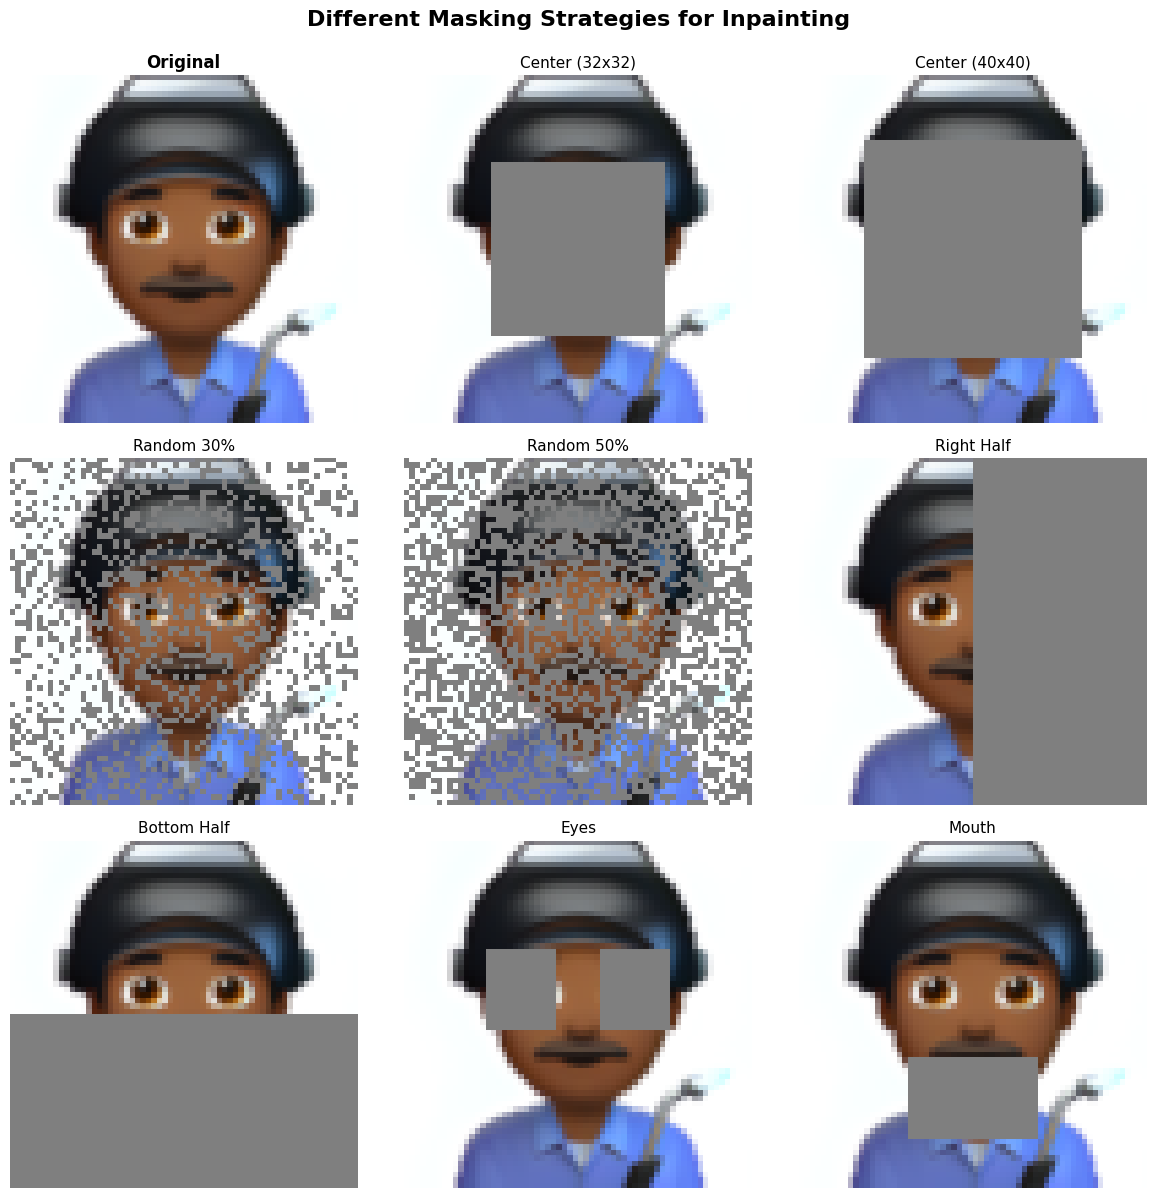

In [15]:
# Visualize Masking Strategies

sample_image = next(iter(val_loader))[:1].to(device)

masks = {
    'Center (32x32)': create_center_mask(IMAGE_SIZE, 32),
    'Center (40x40)': create_center_mask(IMAGE_SIZE, 40),
    'Random 30%': create_random_mask(IMAGE_SIZE, 0.3),
    'Random 50%': create_random_mask(IMAGE_SIZE, 0.5),
    'Right Half': create_half_mask(IMAGE_SIZE, 'right'),
    'Bottom Half': create_half_mask(IMAGE_SIZE, 'bottom'),
    'Eyes': create_eye_mask(IMAGE_SIZE),
    'Mouth': create_mouth_mask(IMAGE_SIZE)
}

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

axes[0].imshow(sample_image[0].cpu().permute(1, 2, 0))
axes[0].set_title('Original', fontsize=12, fontweight='bold')
axes[0].axis('off')

for idx, (name, mask) in enumerate(masks.items(), 1):
    masked = apply_mask(sample_image, mask.to(device))
    axes[idx].imshow(masked[0].cpu().permute(1, 2, 0))
    axes[idx].set_title(name, fontsize=11)
    axes[idx].axis('off')

plt.suptitle('Different Masking Strategies for Inpainting', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [16]:
# Inpainting Functions
@torch.no_grad()
def inpaint_with_prior(vqvae_model, prior_model, masked_image, mask,
                       num_iterations=10, temperature=0.8, top_k=50):
    """Inpaint masked regions using the transformer prior"""
    vqvae_model.eval()
    prior_model.eval()

    # Encode the masked image
    z = vqvae_model.encoder(masked_image)
    z_permuted = z.permute(0, 2, 3, 1).contiguous()
    z_flattened = z_permuted.view(-1, vqvae_model.vq.embedding_dim)

    # Get discrete codes
    distances = (z_flattened.pow(2).sum(1, keepdim=True)
                - 2 * z_flattened @ vqvae_model.vq.embeddings.weight.t()
                + vqvae_model.vq.embeddings.weight.pow(2).sum(1, keepdim=True).t())
    indices = torch.argmin(distances, dim=1)
    codes = indices.view(z.shape[0], z.shape[2], z.shape[3])

    # Downsample mask to latent space
    latent_size_img = codes.shape[1]
    mask_latent = F.interpolate(mask, size=(latent_size_img, latent_size_img), mode='nearest')
    mask_latent = (mask_latent > 0.5).float()

    codes_flat = codes.view(codes.shape[0], -1)
    mask_flat = mask_latent.view(mask_latent.shape[0], -1).squeeze(1)

    # Iteratively refine masked positions
    for iteration in range(num_iterations):
        # Get predictions
        logits, _ = prior_model(codes_flat)
        logits = logits / temperature

        # Apply top-k sampling
        if top_k is not None:
            v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
            logits[logits < v[:, :, [-1]]] = -float('Inf')

        # Sample new codes
        probs = F.softmax(logits, dim=-1)
        sampled_codes = torch.multinomial(probs.view(-1, probs.size(-1)), num_samples=1)
        sampled_codes = sampled_codes.view(codes_flat.shape[0], -1)

        # Only update masked positions (keep as long tensor)
        mask_bool = (mask_flat < 0.5)  # True where we should inpaint
        codes_flat = torch.where(mask_bool, sampled_codes, codes_flat)

    # Decode to image
    codes_2d = codes_flat.view(codes.shape[0], latent_size_img, latent_size_img)
    quantized = vqvae_model.vq.embeddings(codes_2d)
    quantized = quantized.permute(0, 3, 1, 2).contiguous()
    inpainted = vqvae_model.decoder(quantized)

    # Blend with original
    result = masked_image * mask + inpainted * (1 - mask)
    return result, inpainted

@torch.no_grad()
def inpaint_direct(vqvae_model, masked_image, mask):
    """Direct inpainting without prior"""
    vqvae_model.eval()
    z = vqvae_model.encoder(masked_image)
    quantized, _, _, _ = vqvae_model.vq(z)
    reconstructed = vqvae_model.decoder(quantized)
    result = masked_image * mask + reconstructed * (1 - mask)
    return result

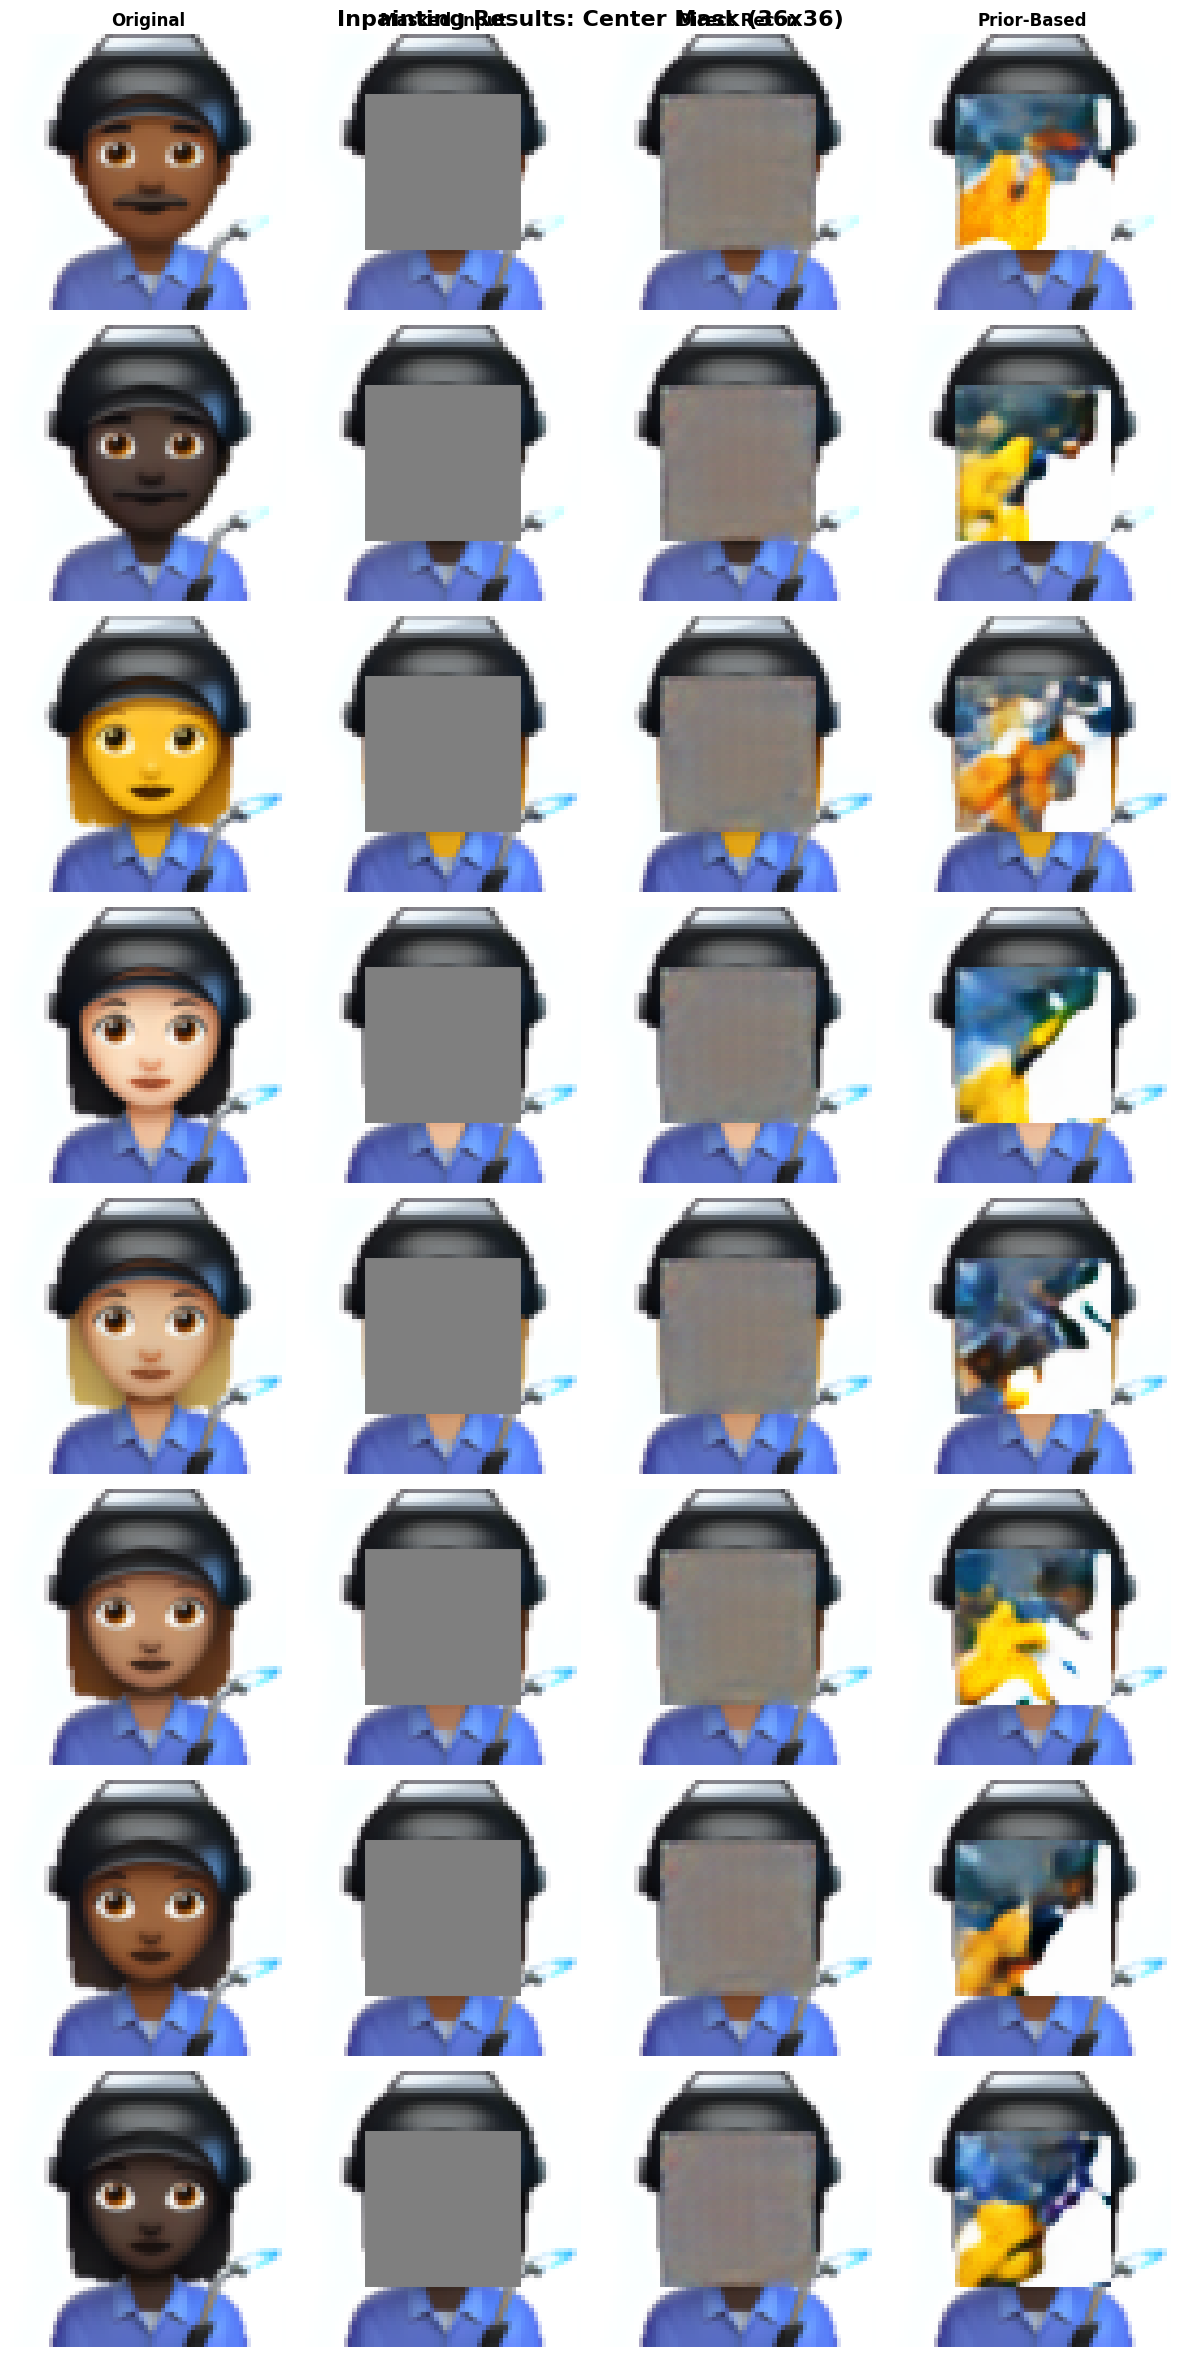

In [17]:
# Test Inpainting with Center Mask

test_samples = next(iter(val_loader))[:8].to(device)
center_mask = create_center_mask(IMAGE_SIZE, 36).to(device)

results = []
for img in test_samples:
    img = img.unsqueeze(0)
    masked_img = apply_mask(img, center_mask)

    direct_result = inpaint_direct(model, masked_img, center_mask)
    prior_result, _ = inpaint_with_prior(model, transformer_prior, masked_img,
                                         center_mask, num_iterations=15, temperature=0.8)

    results.append({
        'original': img,
        'masked': masked_img,
        'direct': direct_result,
        'prior': prior_result
    })

fig, axes = plt.subplots(8, 4, figsize=(12, 24))

for i in range(8):
    axes[i, 0].imshow(results[i]['original'][0].cpu().permute(1, 2, 0))
    if i == 0:
        axes[i, 0].set_title('Original', fontsize=12, fontweight='bold')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(results[i]['masked'][0].cpu().permute(1, 2, 0))
    if i == 0:
        axes[i, 1].set_title('Masked Input', fontsize=12, fontweight='bold')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(results[i]['direct'][0].cpu().permute(1, 2, 0))
    if i == 0:
        axes[i, 2].set_title('Direct Recon', fontsize=12, fontweight='bold')
    axes[i, 2].axis('off')

    axes[i, 3].imshow(results[i]['prior'][0].cpu().permute(1, 2, 0))
    if i == 0:
        axes[i, 3].set_title('Prior-Based', fontsize=12, fontweight='bold')
    axes[i, 3].axis('off')

plt.suptitle('Inpainting Results: Center Mask (36x36)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

🎭 Testing multiple masking strategies...


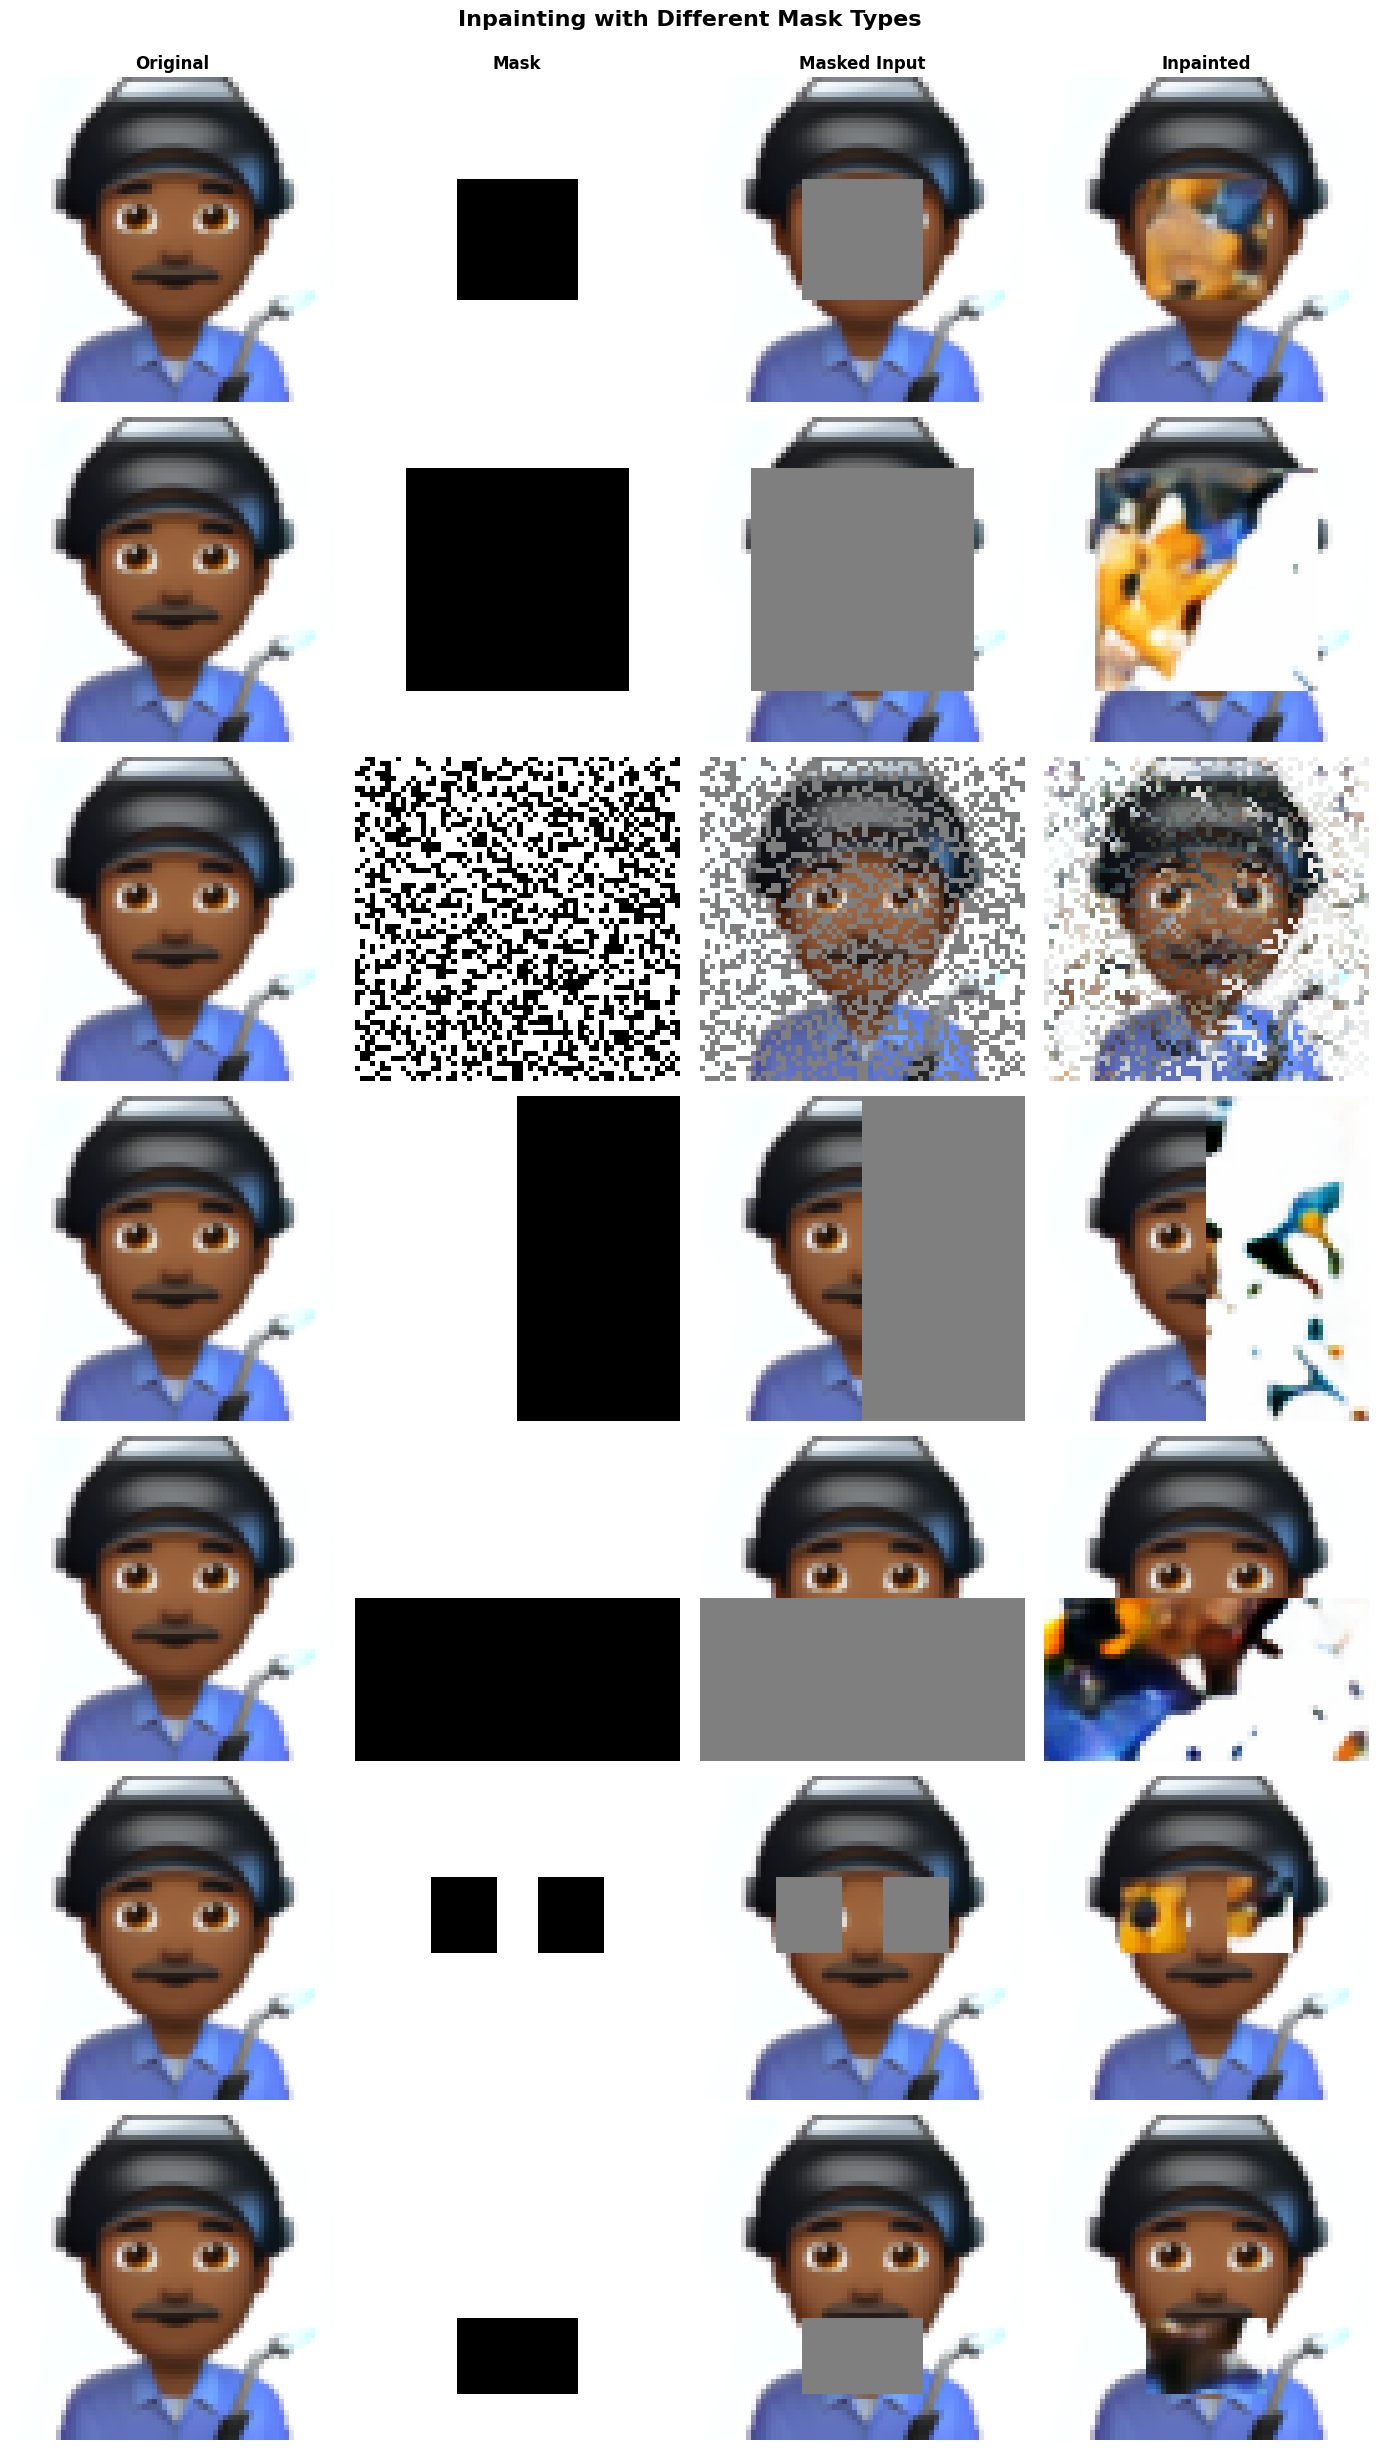

In [18]:
# Test Multiple Mask Types
print("🎭 Testing multiple masking strategies...")

test_image = next(iter(val_loader))[:1].to(device)

mask_configs = [
    ('Center Small', create_center_mask(IMAGE_SIZE, 24)),
    ('Center Large', create_center_mask(IMAGE_SIZE, 44)),
    ('Random 40%', create_random_mask(IMAGE_SIZE, 0.4)),
    ('Right Half', create_half_mask(IMAGE_SIZE, 'right')),
    ('Bottom Half', create_half_mask(IMAGE_SIZE, 'bottom')),
    ('Eyes', create_eye_mask(IMAGE_SIZE)),
    ('Mouth', create_mouth_mask(IMAGE_SIZE)),
]

fig, axes = plt.subplots(len(mask_configs), 4, figsize=(14, 3.5*len(mask_configs)))

for idx, (mask_name, mask) in enumerate(mask_configs):
    mask = mask.to(device)
    masked_img = apply_mask(test_image, mask)
    inpainted, _ = inpaint_with_prior(model, transformer_prior, masked_img,
                                      mask, num_iterations=20, temperature=0.75)

    axes[idx, 0].imshow(test_image[0].cpu().permute(1, 2, 0))
    axes[idx, 0].set_ylabel(mask_name, fontsize=11, fontweight='bold', rotation=0,
                            ha='right', va='center', labelpad=40)
    axes[idx, 0].axis('off')
    if idx == 0:
        axes[idx, 0].set_title('Original', fontsize=12, fontweight='bold')

    axes[idx, 1].imshow(mask[0, 0].cpu(), cmap='gray')
    axes[idx, 1].axis('off')
    if idx == 0:
        axes[idx, 1].set_title('Mask', fontsize=12, fontweight='bold')

    axes[idx, 2].imshow(masked_img[0].cpu().permute(1, 2, 0))
    axes[idx, 2].axis('off')
    if idx == 0:
        axes[idx, 2].set_title('Masked Input', fontsize=12, fontweight='bold')

    axes[idx, 3].imshow(inpainted[0].cpu().permute(1, 2, 0))
    axes[idx, 3].axis('off')
    if idx == 0:
        axes[idx, 3].set_title('Inpainted', fontsize=12, fontweight='bold')

plt.suptitle('Inpainting with Different Mask Types', fontsize=16, fontweight='bold', y=0.998)
plt.tight_layout()
plt.show()

Testing temperature effects...


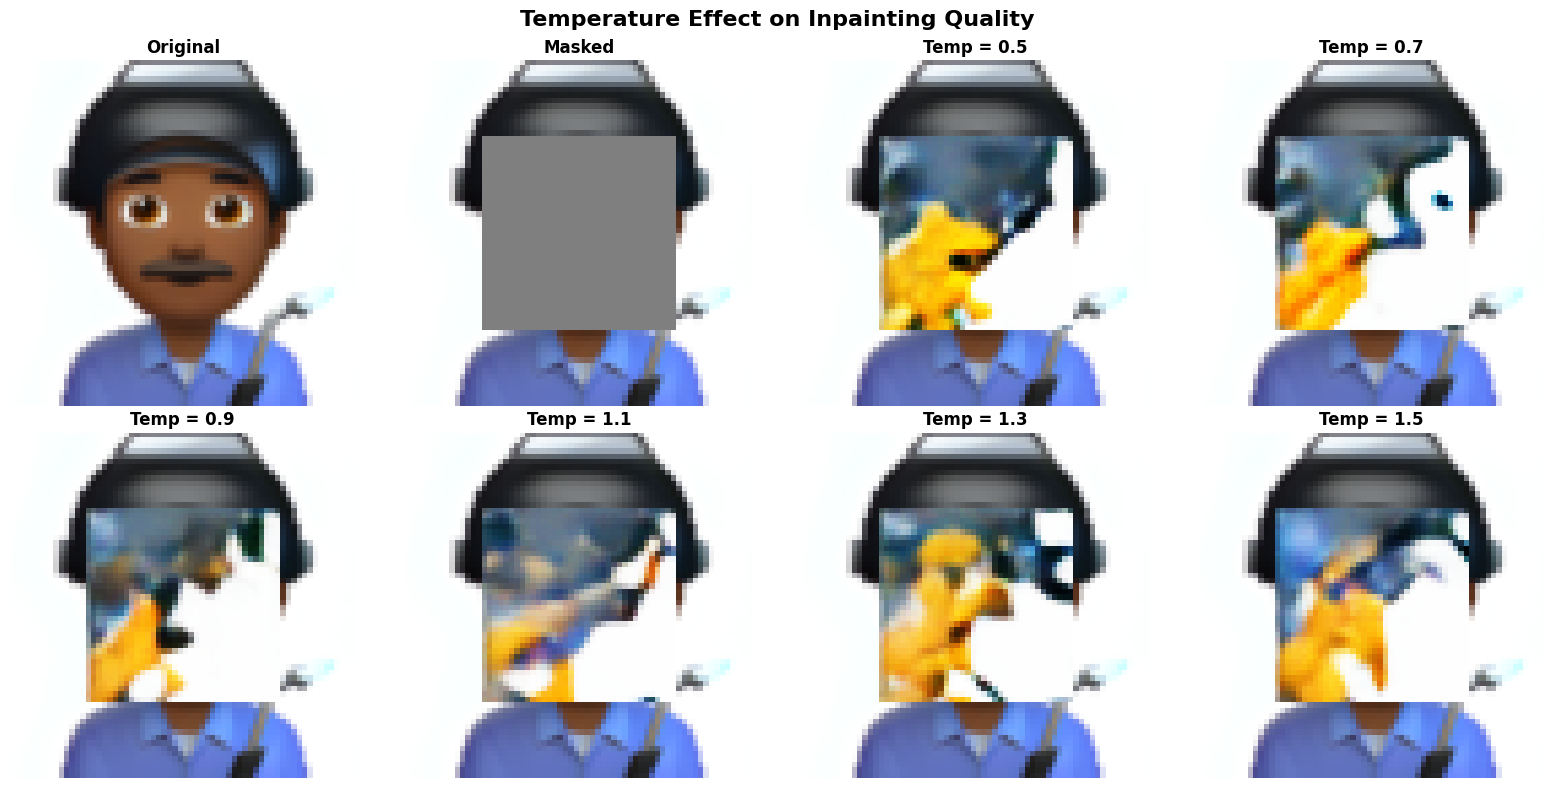

In [24]:
# Temperature Effects
print("Testing temperature effects...")

test_img = next(iter(val_loader))[:1].to(device)
mask = create_center_mask(IMAGE_SIZE, 36).to(device)
masked_img = apply_mask(test_img, mask)

temperatures = [0.5, 0.7, 0.9, 1.1, 1.3, 1.5]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

axes[0].imshow(test_img[0].cpu().permute(1, 2, 0))
axes[0].set_title('Original', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(masked_img[0].cpu().permute(1, 2, 0))
axes[1].set_title('Masked', fontsize=12, fontweight='bold')
axes[1].axis('off')

for idx, temp in enumerate(temperatures, 2):
    inpainted, _ = inpaint_with_prior(model, transformer_prior, masked_img, mask,
                                      num_iterations=15, temperature=temp, top_k=50)
    axes[idx].imshow(inpainted[0].cpu().permute(1, 2, 0))
    axes[idx].set_title(f'Temp = {temp}', fontsize=12, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle('Temperature Effect on Inpainting Quality', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Generating multiple inpainting variations...


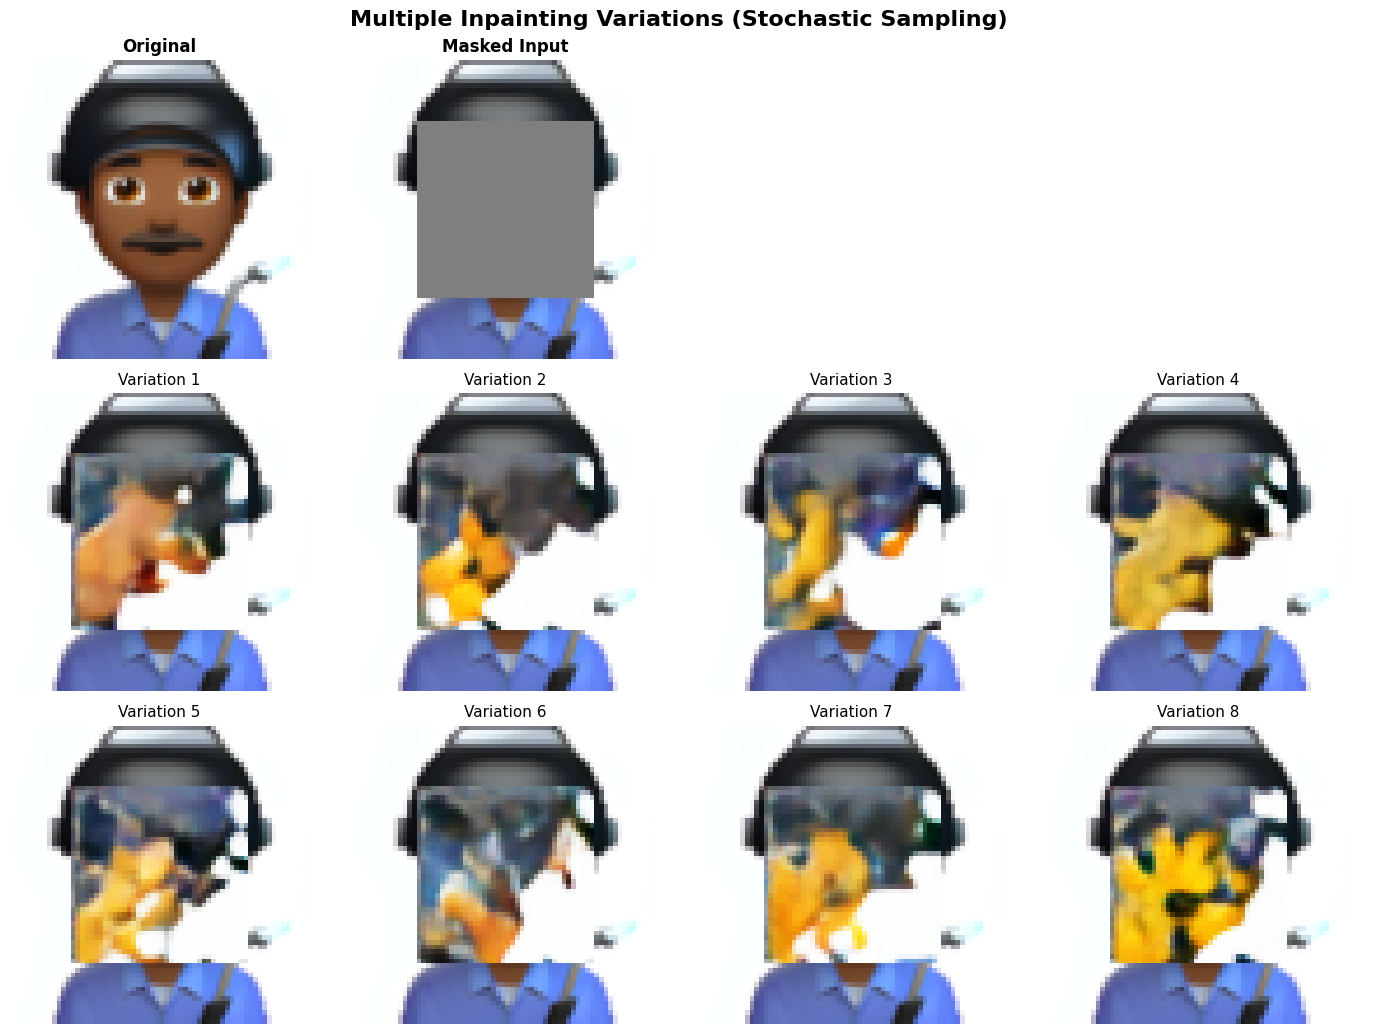

In [20]:
# Multiple Variations
print("Generating multiple inpainting variations...")

test_img = next(iter(val_loader))[:1].to(device)
mask = create_center_mask(IMAGE_SIZE, 38).to(device)
masked_img = apply_mask(test_img, mask)

# Generate 8 variations (not 9) to fit the grid
variations = []
for i in range(8):
    inpainted, _ = inpaint_with_prior(model, transformer_prior, masked_img, mask,
                                      num_iterations=15, temperature=1.0, top_k=100)
    variations.append(inpainted)

fig, axes = plt.subplots(3, 4, figsize=(14, 10.5))

axes[0, 0].imshow(test_img[0].cpu().permute(1, 2, 0))
axes[0, 0].set_title('Original', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(masked_img[0].cpu().permute(1, 2, 0))
axes[0, 1].set_title('Masked Input', fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

axes[0, 2].axis('off')
axes[0, 3].axis('off')

# Place variations starting from row 1
for idx, var in enumerate(variations):
    row = 1 + idx // 4
    col = idx % 4
    axes[row, col].imshow(var[0].cpu().permute(1, 2, 0))
    axes[row, col].set_title(f'Variation {idx+1}', fontsize=11)
    axes[row, col].axis('off')

plt.suptitle('Multiple Inpainting Variations (Stochastic Sampling)',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Creating final showcase gallery...


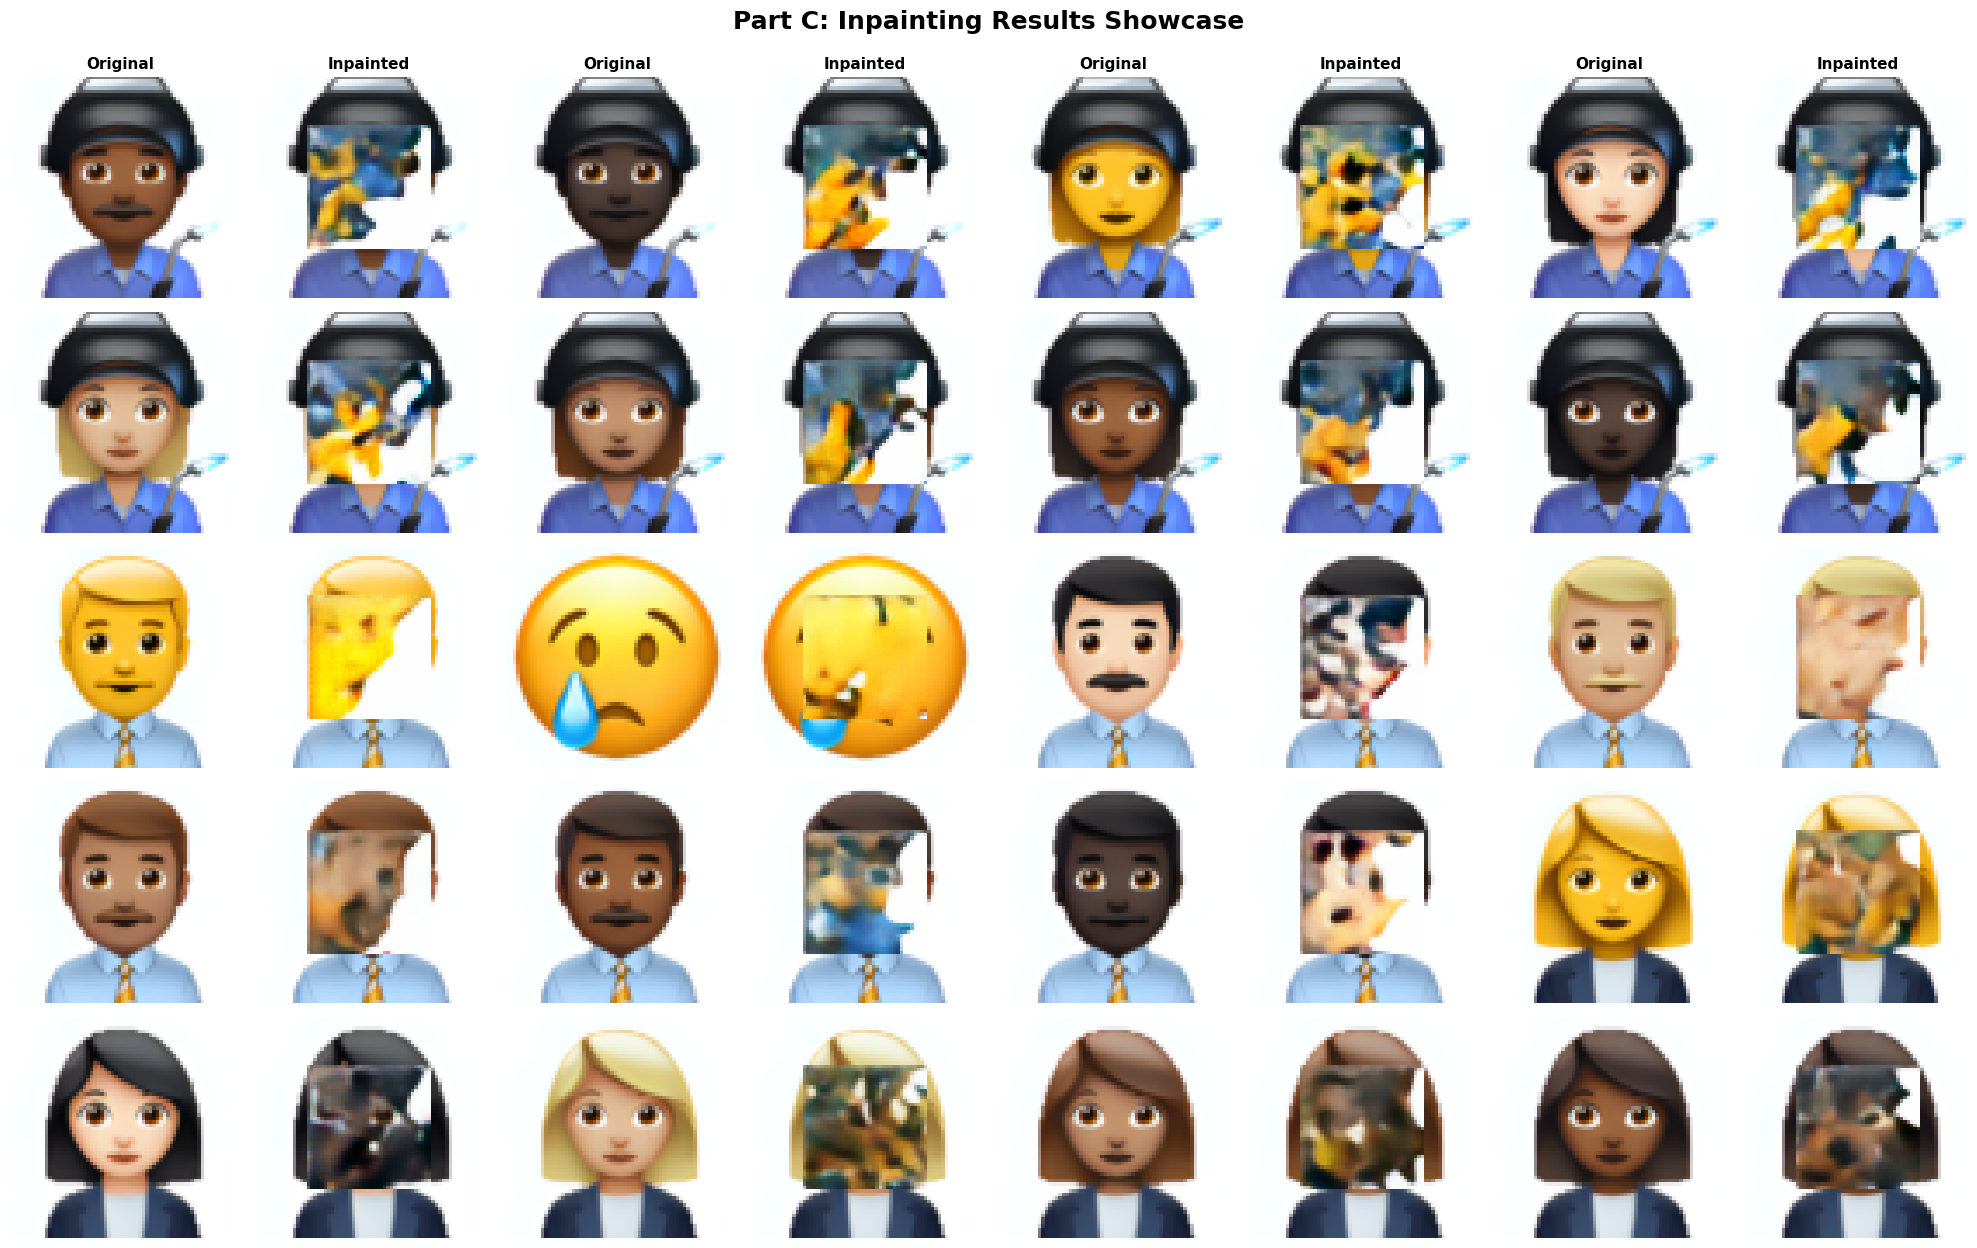

In [21]:
# Final Showcase
print("Creating final showcase gallery...")

showcase_samples = next(iter(val_loader))[:20].to(device)
mask = create_center_mask(IMAGE_SIZE, 36).to(device)

fig, axes = plt.subplots(5, 8, figsize=(20, 12.5))

for i in range(20):
    img = showcase_samples[i:i+1]
    masked_img = apply_mask(img, mask)
    inpainted, _ = inpaint_with_prior(model, transformer_prior, masked_img, mask,
                                      num_iterations=15, temperature=0.85, top_k=60)

    row = i // 4
    col = (i % 4) * 2

    axes[row, col].imshow(img[0].cpu().permute(1, 2, 0))
    if i % 4 == 0:
        axes[row, col].set_ylabel(f'Sample {i//4 + 1}', fontsize=10,
                                  fontweight='bold', rotation=0, ha='right',
                                  va='center', labelpad=30)
    axes[row, col].axis('off')
    if row == 0:
        axes[row, col].set_title('Original', fontsize=11, fontweight='bold')

    axes[row, col + 1].imshow(inpainted[0].cpu().permute(1, 2, 0))
    axes[row, col + 1].axis('off')
    if row == 0:
        axes[row, col + 1].set_title('Inpainted', fontsize=11, fontweight='bold')

plt.suptitle('Part C: Inpainting Results Showcase', fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

Quantitative Evaluation of Inpainting...

Evaluating different masking strategies...

Evaluating: Center 24x24


Evaluating:  20%|██        | 1/5 [00:06<00:24,  6.21s/it]


Evaluating: Center 36x36


Evaluating:  20%|██        | 1/5 [00:03<00:14,  3.52s/it]


Evaluating: Center 44x44


Evaluating:  20%|██        | 1/5 [00:03<00:14,  3.54s/it]


Evaluating: Random 30%


Evaluating:  20%|██        | 1/5 [00:03<00:15,  3.82s/it]


Evaluating: Right Half


Evaluating:  20%|██        | 1/5 [00:03<00:15,  3.95s/it]



INPAINTING EVALUATION RESULTS

Center 24x24:
  MSE:  0.080952 ± 0.043437
  PSNR: 11.49 ± 2.26 dB
  SSIM: 0.8304 ± 0.0196

Center 36x36:
  MSE:  0.147574 ± 0.062781
  PSNR: 8.69 ± 1.83 dB
  SSIM: 0.5945 ± 0.0262

Center 44x44:
  MSE:  0.183723 ± 0.058709
  PSNR: 7.59 ± 1.44 dB
  SSIM: 0.3960 ± 0.0279

Random 30%:
  MSE:  0.071066 ± 0.010747
  PSNR: 11.53 ± 0.67 dB
  SSIM: 0.5669 ± 0.0426

Right Half:
  MSE:  0.178170 ± 0.062545
  PSNR: 7.79 ± 1.67 dB
  SSIM: 0.5471 ± 0.0316


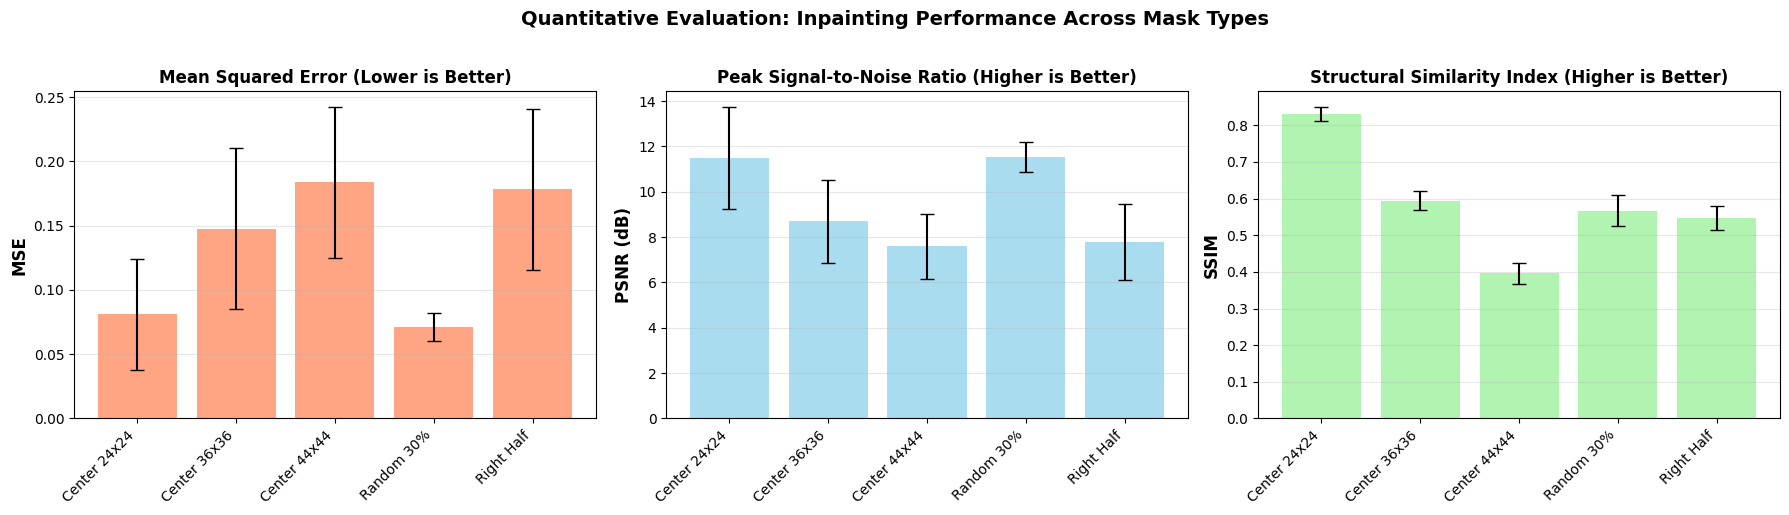

/tmp/ipython-input-376638182.py:161: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = axes[0].boxplot(mse_data, labels=mask_names, patch_artist=True)
/tmp/ipython-input-376638182.py:171: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = axes[1].boxplot(psnr_data, labels=mask_names, patch_artist=True)
/tmp/ipython-input-376638182.py:181: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp3 = axes[2].boxplot(ssim_data, labels=mask_names, patch_artist=True)


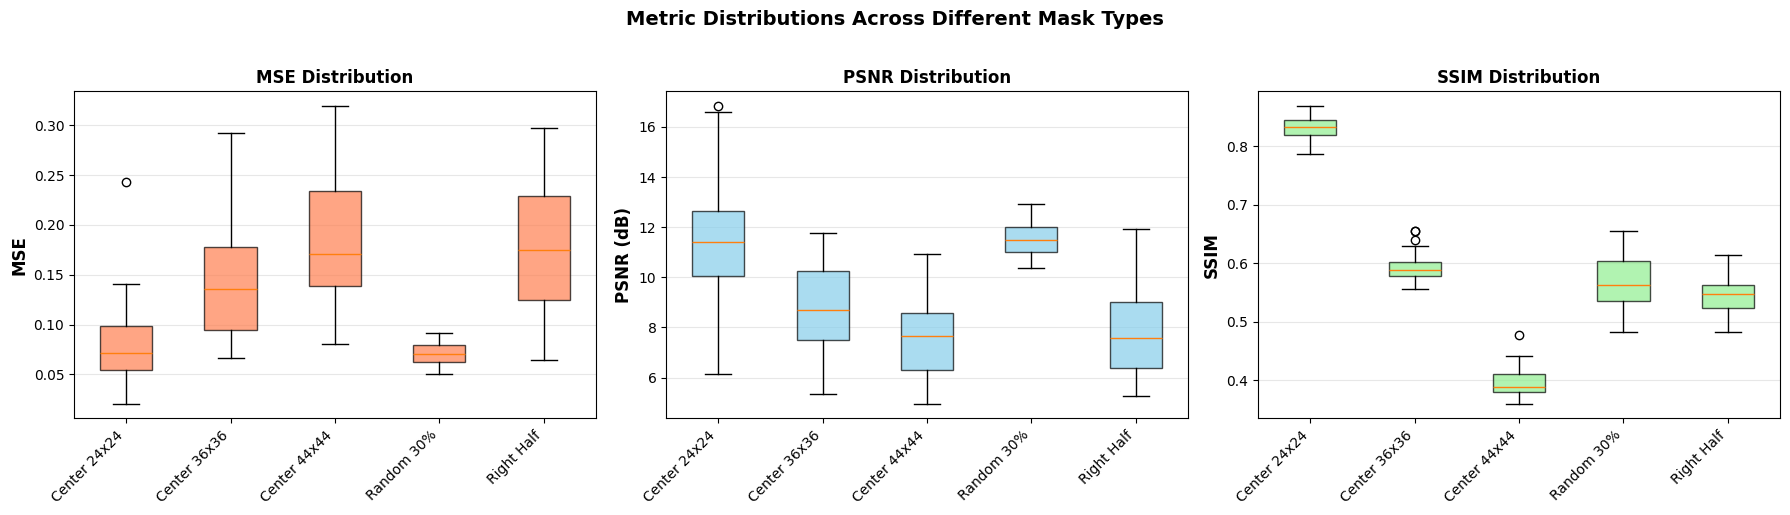


Quantitative evaluation completed!


In [23]:
# Quantitative Evaluation of Inpainting
print("Quantitative Evaluation of Inpainting...")

@torch.no_grad()
def evaluate_inpainting(vqvae_model, prior_model, loader, mask, num_samples=50):
    """Evaluate inpainting quality"""
    vqvae_model.eval()
    prior_model.eval()

    mse_scores = []
    psnr_scores = []
    ssim_scores = []

    count = 0
    for batch in tqdm(loader, desc="Evaluating"):
        if count >= num_samples:
            break

        batch = batch.to(device)
        for img in batch:
            if count >= num_samples:
                break

            img = img.unsqueeze(0)
            masked_img = apply_mask(img, mask)

            # Inpaint
            inpainted, _ = inpaint_with_prior(vqvae_model, prior_model, masked_img,
                                             mask, num_iterations=15, temperature=0.8)

            # Calculate metrics only in masked region
            mask_np = mask[0, 0].cpu().numpy()
            mask_bool = mask_np < 0.5  # True where we inpainted

            original_full = img[0].cpu().permute(1, 2, 0).numpy()
            inpainted_full = inpainted[0].cpu().permute(1, 2, 0).numpy()

            # Extract masked regions for each channel
            mse_per_channel = []
            for c in range(3):
                orig_channel = original_full[:, :, c][mask_bool]
                inpaint_channel = inpainted_full[:, :, c][mask_bool]
                mse_channel = np.mean((orig_channel - inpaint_channel) ** 2)
                mse_per_channel.append(mse_channel)

            mse = np.mean(mse_per_channel)
            mse_scores.append(mse)

            # PSNR
            if mse > 0:
                psnr = 10 * np.log10(1.0 / mse)
                psnr_scores.append(psnr)

            # SSIM (on full image)
            ssim_val = ssim(original_full, inpainted_full, channel_axis=2, data_range=1.0)
            ssim_scores.append(ssim_val)

            count += 1

    return {
        'mse': np.mean(mse_scores),
        'psnr': np.mean(psnr_scores),
        'ssim': np.mean(ssim_scores),
        'mse_std': np.std(mse_scores),
        'psnr_std': np.std(psnr_scores),
        'ssim_std': np.std(ssim_scores),
        'mse_scores': mse_scores,
        'psnr_scores': psnr_scores,
        'ssim_scores': ssim_scores
    }

# Evaluate different mask types
print("\nEvaluating different masking strategies...\n")

mask_types = {
    'Center 24x24': create_center_mask(IMAGE_SIZE, 24).to(device),
    'Center 36x36': create_center_mask(IMAGE_SIZE, 36).to(device),
    'Center 44x44': create_center_mask(IMAGE_SIZE, 44).to(device),
    'Random 30%': create_random_mask(IMAGE_SIZE, 0.3).to(device),
    'Right Half': create_half_mask(IMAGE_SIZE, 'right').to(device),
}

results_table = []
all_metrics = {}

for mask_name, mask in mask_types.items():
    print(f"Evaluating: {mask_name}")
    metrics = evaluate_inpainting(model, transformer_prior, val_loader, mask, num_samples=30)
    all_metrics[mask_name] = metrics

    results_table.append({
        'Mask Type': mask_name,
        'MSE': f"{metrics['mse']:.6f} ± {metrics['mse_std']:.6f}",
        'PSNR': f"{metrics['psnr']:.2f} ± {metrics['psnr_std']:.2f}",
        'SSIM': f"{metrics['ssim']:.4f} ± {metrics['ssim_std']:.4f}"
    })

# Display results table
print("\n" + "="*80)
print("INPAINTING EVALUATION RESULTS")
print("="*80)
for result in results_table:
    print(f"\n{result['Mask Type']}:")
    print(f"  MSE:  {result['MSE']}")
    print(f"  PSNR: {result['PSNR']} dB")
    print(f"  SSIM: {result['SSIM']}")
print("="*80)

# Visualize metrics comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

mask_names = list(mask_types.keys())
mse_means = [all_metrics[m]['mse'] for m in mask_names]
psnr_means = [all_metrics[m]['psnr'] for m in mask_names]
ssim_means = [all_metrics[m]['ssim'] for m in mask_names]

mse_stds = [all_metrics[m]['mse_std'] for m in mask_names]
psnr_stds = [all_metrics[m]['psnr_std'] for m in mask_names]
ssim_stds = [all_metrics[m]['ssim_std'] for m in mask_names]

x_pos = np.arange(len(mask_names))

# MSE
axes[0].bar(x_pos, mse_means, yerr=mse_stds, capsize=5, alpha=0.7, color='coral')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(mask_names, rotation=45, ha='right')
axes[0].set_ylabel('MSE', fontsize=12, fontweight='bold')
axes[0].set_title('Mean Squared Error (Lower is Better)', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# PSNR
axes[1].bar(x_pos, psnr_means, yerr=psnr_stds, capsize=5, alpha=0.7, color='skyblue')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(mask_names, rotation=45, ha='right')
axes[1].set_ylabel('PSNR (dB)', fontsize=12, fontweight='bold')
axes[1].set_title('Peak Signal-to-Noise Ratio (Higher is Better)', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# SSIM
axes[2].bar(x_pos, ssim_means, yerr=ssim_stds, capsize=5, alpha=0.7, color='lightgreen')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(mask_names, rotation=45, ha='right')
axes[2].set_ylabel('SSIM', fontsize=12, fontweight='bold')
axes[2].set_title('Structural Similarity Index (Higher is Better)', fontsize=12, fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)

plt.suptitle('Quantitative Evaluation: Inpainting Performance Across Mask Types',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Box plots for metric distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Prepare data for box plots
mse_data = [all_metrics[m]['mse_scores'] for m in mask_names]
psnr_data = [all_metrics[m]['psnr_scores'] for m in mask_names]
ssim_data = [all_metrics[m]['ssim_scores'] for m in mask_names]

# MSE distribution
bp1 = axes[0].boxplot(mse_data, labels=mask_names, patch_artist=True)
for patch in bp1['boxes']:
    patch.set_facecolor('coral')
    patch.set_alpha(0.7)
axes[0].set_xticklabels(mask_names, rotation=45, ha='right')
axes[0].set_ylabel('MSE', fontsize=12, fontweight='bold')
axes[0].set_title('MSE Distribution', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# PSNR distribution
bp2 = axes[1].boxplot(psnr_data, labels=mask_names, patch_artist=True)
for patch in bp2['boxes']:
    patch.set_facecolor('skyblue')
    patch.set_alpha(0.7)
axes[1].set_xticklabels(mask_names, rotation=45, ha='right')
axes[1].set_ylabel('PSNR (dB)', fontsize=12, fontweight='bold')
axes[1].set_title('PSNR Distribution', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# SSIM distribution
bp3 = axes[2].boxplot(ssim_data, labels=mask_names, patch_artist=True)
for patch in bp3['boxes']:
    patch.set_facecolor('lightgreen')
    patch.set_alpha(0.7)
axes[2].set_xticklabels(mask_names, rotation=45, ha='right')
axes[2].set_ylabel('SSIM', fontsize=12, fontweight='bold')
axes[2].set_title('SSIM Distribution', fontsize=12, fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)

plt.suptitle('Metric Distributions Across Different Mask Types',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()